In [2]:
import pandas
import numpy
import umap
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.neighbors import NearestNeighbors

In [3]:
def get_plot_limit(v):
    # get the limit for a scatter plot that will exclude outliers
    
    inliers = numpy.where(abs(v - numpy.nanmean(v))/numpy.nanstd(v) < 5)[0]
    min_lim = numpy.nanmin(v[inliers])- numpy.nanstd(v)*0.1
    max_lim = numpy.nanmax(v[inliers])+ numpy.nanstd(v)*0.1
    
    #min_lim = numpy.nanpercentile(v, 1) - numpy.nanstd(v)*0.25
    #max_lim = numpy.nanpercentile(v, 99) + numpy.nanstd(v)*0.25
    
    return [min_lim, max_lim]

import matplotlib.image as mpimg
def print_sdss_link(SpecObjID):
    SpecObjID = str(int(SpecObjID))
    print('http://skyserver.sdss.org/dr14/en/tools/explore/summary.aspx?sid=' + str(SpecObjID) + '&apid=')
    return
def show_sdss_spectra(specobjid):
    print_sdss_link(specobjid)
    plt.figure(figsize = (10,7))
    plt.imshow(mpimg.imread('http://skyserver.sdss.org/dr14/en/get/SpecById.ashx?id=' + dr14_specobjid))
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
from matplotlib.widgets import RectangleSelector

def get_inds_click(tmap, xmn, xmx, ymn, ymx):
    inds = numpy.where((tmap[:,0] > xmn) & (tmap[:,0] < xmx) & (tmap[:,1] > ymn) & (tmap[:,1] < ymx))[0]
    return inds

def line_select_callback(eclick, erelease):
    x1, y1 = eclick.xdata, eclick.ydata
    x2, y2 = erelease.xdata, erelease.ydata
    global selected_inds
    selected_inds = get_inds_click(click_map, min(x1,x2), max(x1,x2), min(y1,y2), max(y1,y2))
      
    art = plt.scatter(click_map[click_inds,0], click_map[click_inds,1], s = 100, edgecolors='red', c='none')

def toggle_selector(event):
    if event.key in ['Q', 'q'] and toggle_selector.RS.active:
        toggle_selector.RS.set_active(False)
    if event.key in ['A', 'a'] and not toggle_selector.RS.active:
        toggle_selector.RS.set_active(True)

In [4]:
%matplotlib notebook

In [5]:
w = numpy.load('data/wavelength_grid_red.npy')
X = numpy.load('data/spectra_red.npy')
SpecObjIDS = numpy.load('data/specobjids_red.npy').astype(int)
nof_objects = X.shape[0]
nof_features = X.shape[1]
print('Number of galaxies: {}\nNumber of flux values: {}'.format(nof_objects, nof_features))

Number of galaxies: 50000
Number of flux values: 2676


# UMAP
* https://umap-learn.readthedocs.io

Uniform Manifold Approximation and Projection (UMAP) is a dimension reduction technique that can be used for visualisation similarly to t-SNE, but also for general non-linear dimension reduction. The algorithm is founded on three assumptions about the data

    The data is uniformly distributed on Riemannian manifold;
    The Riemannian metric is locally constant (or can be approximated as such);
    The manifold is locally connected.

From these assumptions it is possible to model the manifold with a fuzzy topological structure. The embedding is found by searching for a low dimensional projection of the data that has the closest possible equivalent fuzzy topological structure.

In [142]:
%%time
print('UMAP is running ...')
n_neighbors, min_dist = 5, 0.01
umap_res = umap.UMAP(n_neighbors=n_neighbors,
                      min_dist=min_dist,
                      metric='euclidean').fit_transform(X)
print('Done!')

UMAP is running ...
Done!
CPU times: user 1min 25s, sys: 16.6 s, total: 1min 42s
Wall time: 1min 57s


<IPython.core.display.Javascript object>


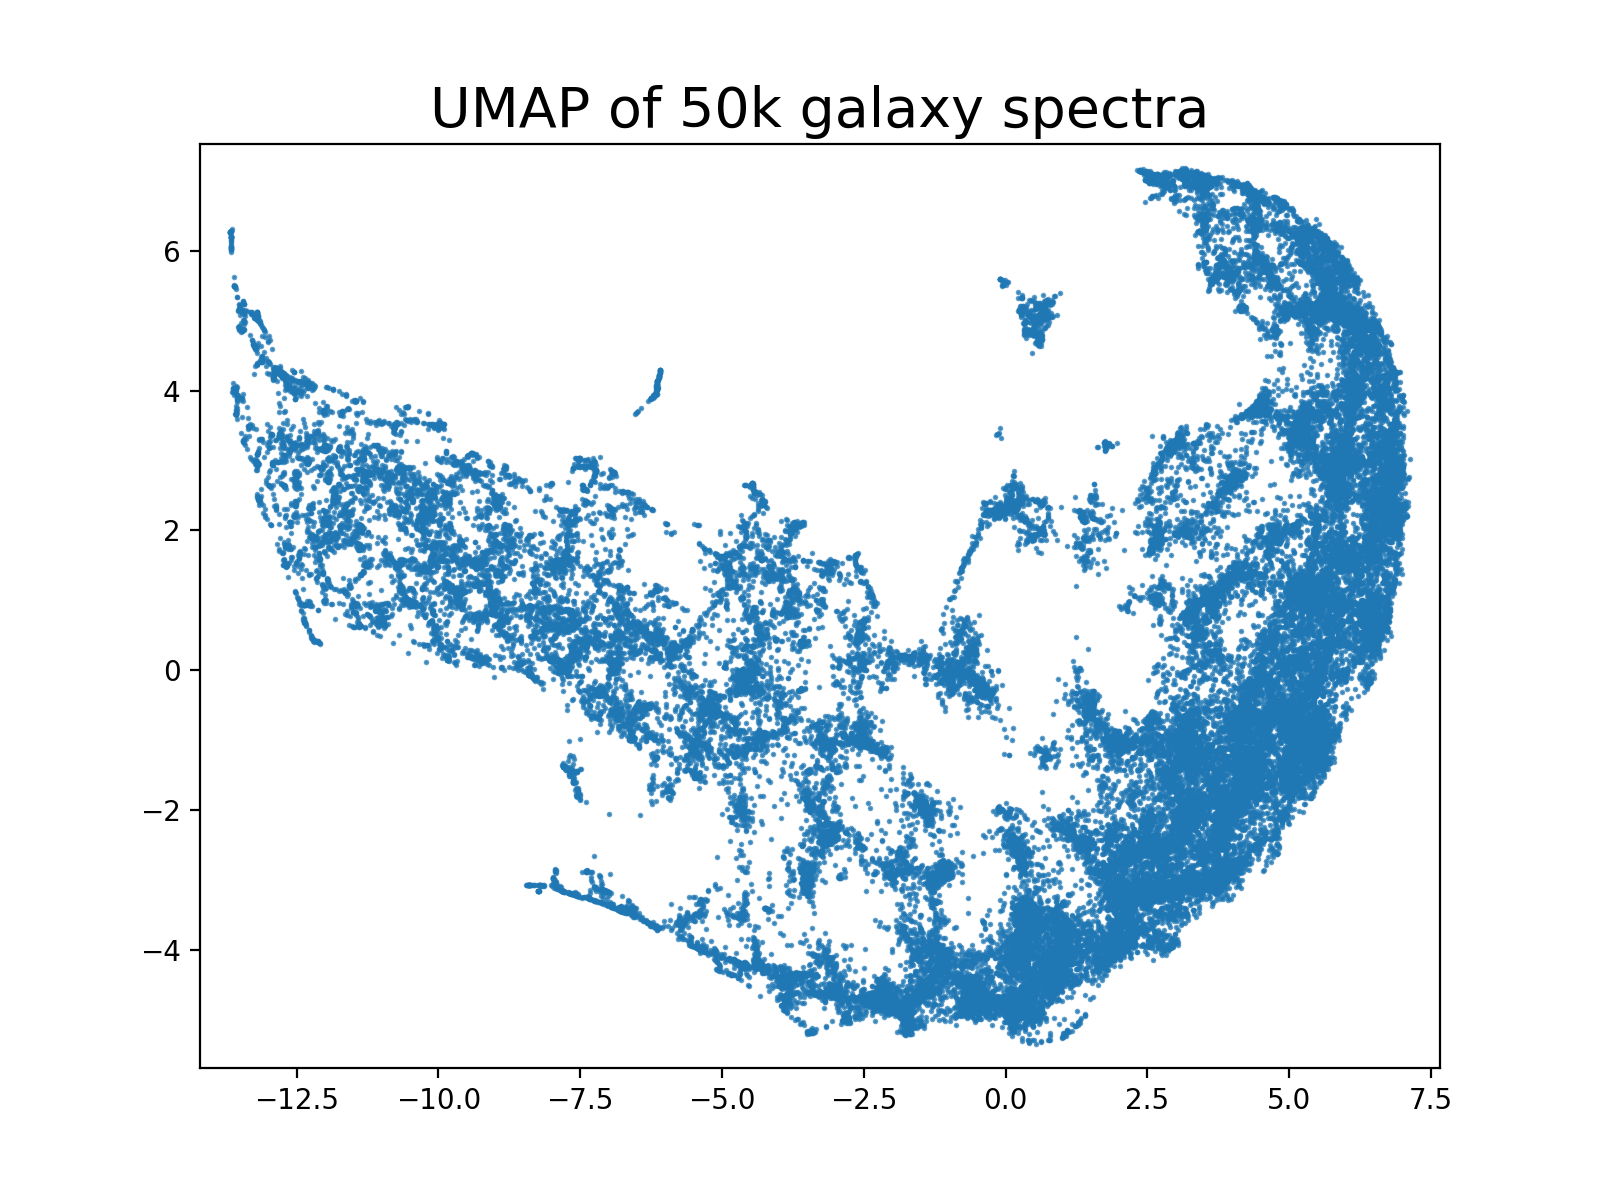

In [160]:
plt.figure(figsize = (8,6))
umap_x = umap_res[:,0]
umap_y = umap_res[:,1]
plt.scatter(umap_x,umap_y, alpha = 0.7, edgecolors=None, s = 1)
plt.title('UMAP of 50k galaxy spectra', fontsize = 20)
#plt.axis('off')
plt.xlim(get_plot_limit(umap_x))
plt.ylim(get_plot_limit(umap_y))
plt.show()

## UMAP paramters:

* n_neighbors - This parameter controls how UMAP balances local versus global structure in the data. It does this by constraining the size of the local neighborhood UMAP will look at when attempting to learn the manifold structure of the data. This means that low values of n_neighbors will force UMAP to concentrate on very local structure (potentially to the detriment of the big picture), while large values will push UMAP to look at larger neighborhoods of each point when estimating the manifold structure of the data, loosing fine detail structure for the sake of getting the broader of the data.


* min_dist - The min_dist parameter controls how tightly UMAP is allowed to pack points together. It, quite literally, provides the minimum distance apart that points are allowed to be in the low dimensional representation. This means that low values of min_dist will result in clumpier embeddings. This can be useful if you are interested in clustering, or in finer topological structure. Larger values of min_dist will prevent UMAP from packing point together and will focus instead on the preservation of the broad topological structure instead.

### Other distance matrices:

#### Minkowski style metrics

* euclidean
* manhattan
* chebyshev
* minkowski

#### Miscellaneous spatial metrics

* canberra
* braycurtis
* haversine

#### Angular and correlation metrics

* cosine
* correlation

and more, see https://umap-learn.readthedocs.io/en/latest/parameters.html#metric

In [7]:
# This will take about half an hour to run. No need to run this yourself, files with the results are included

nn_list = [2,5,10,100]
md_list = [0.01,0.1,0.25,0.5]

#for nn in nn_list:
#    for md in md_list:
#        print(nn, md)
#        %time umap_res = umap.UMAP(n_neighbors=nn,min_dist=md,metric='euclidean').fit_transform(X)
#        numpy.save('umap_results/umap_result_nn_{}_md_{}.npy'.format(nn,md), umap_res)

<IPython.core.display.Javascript object>


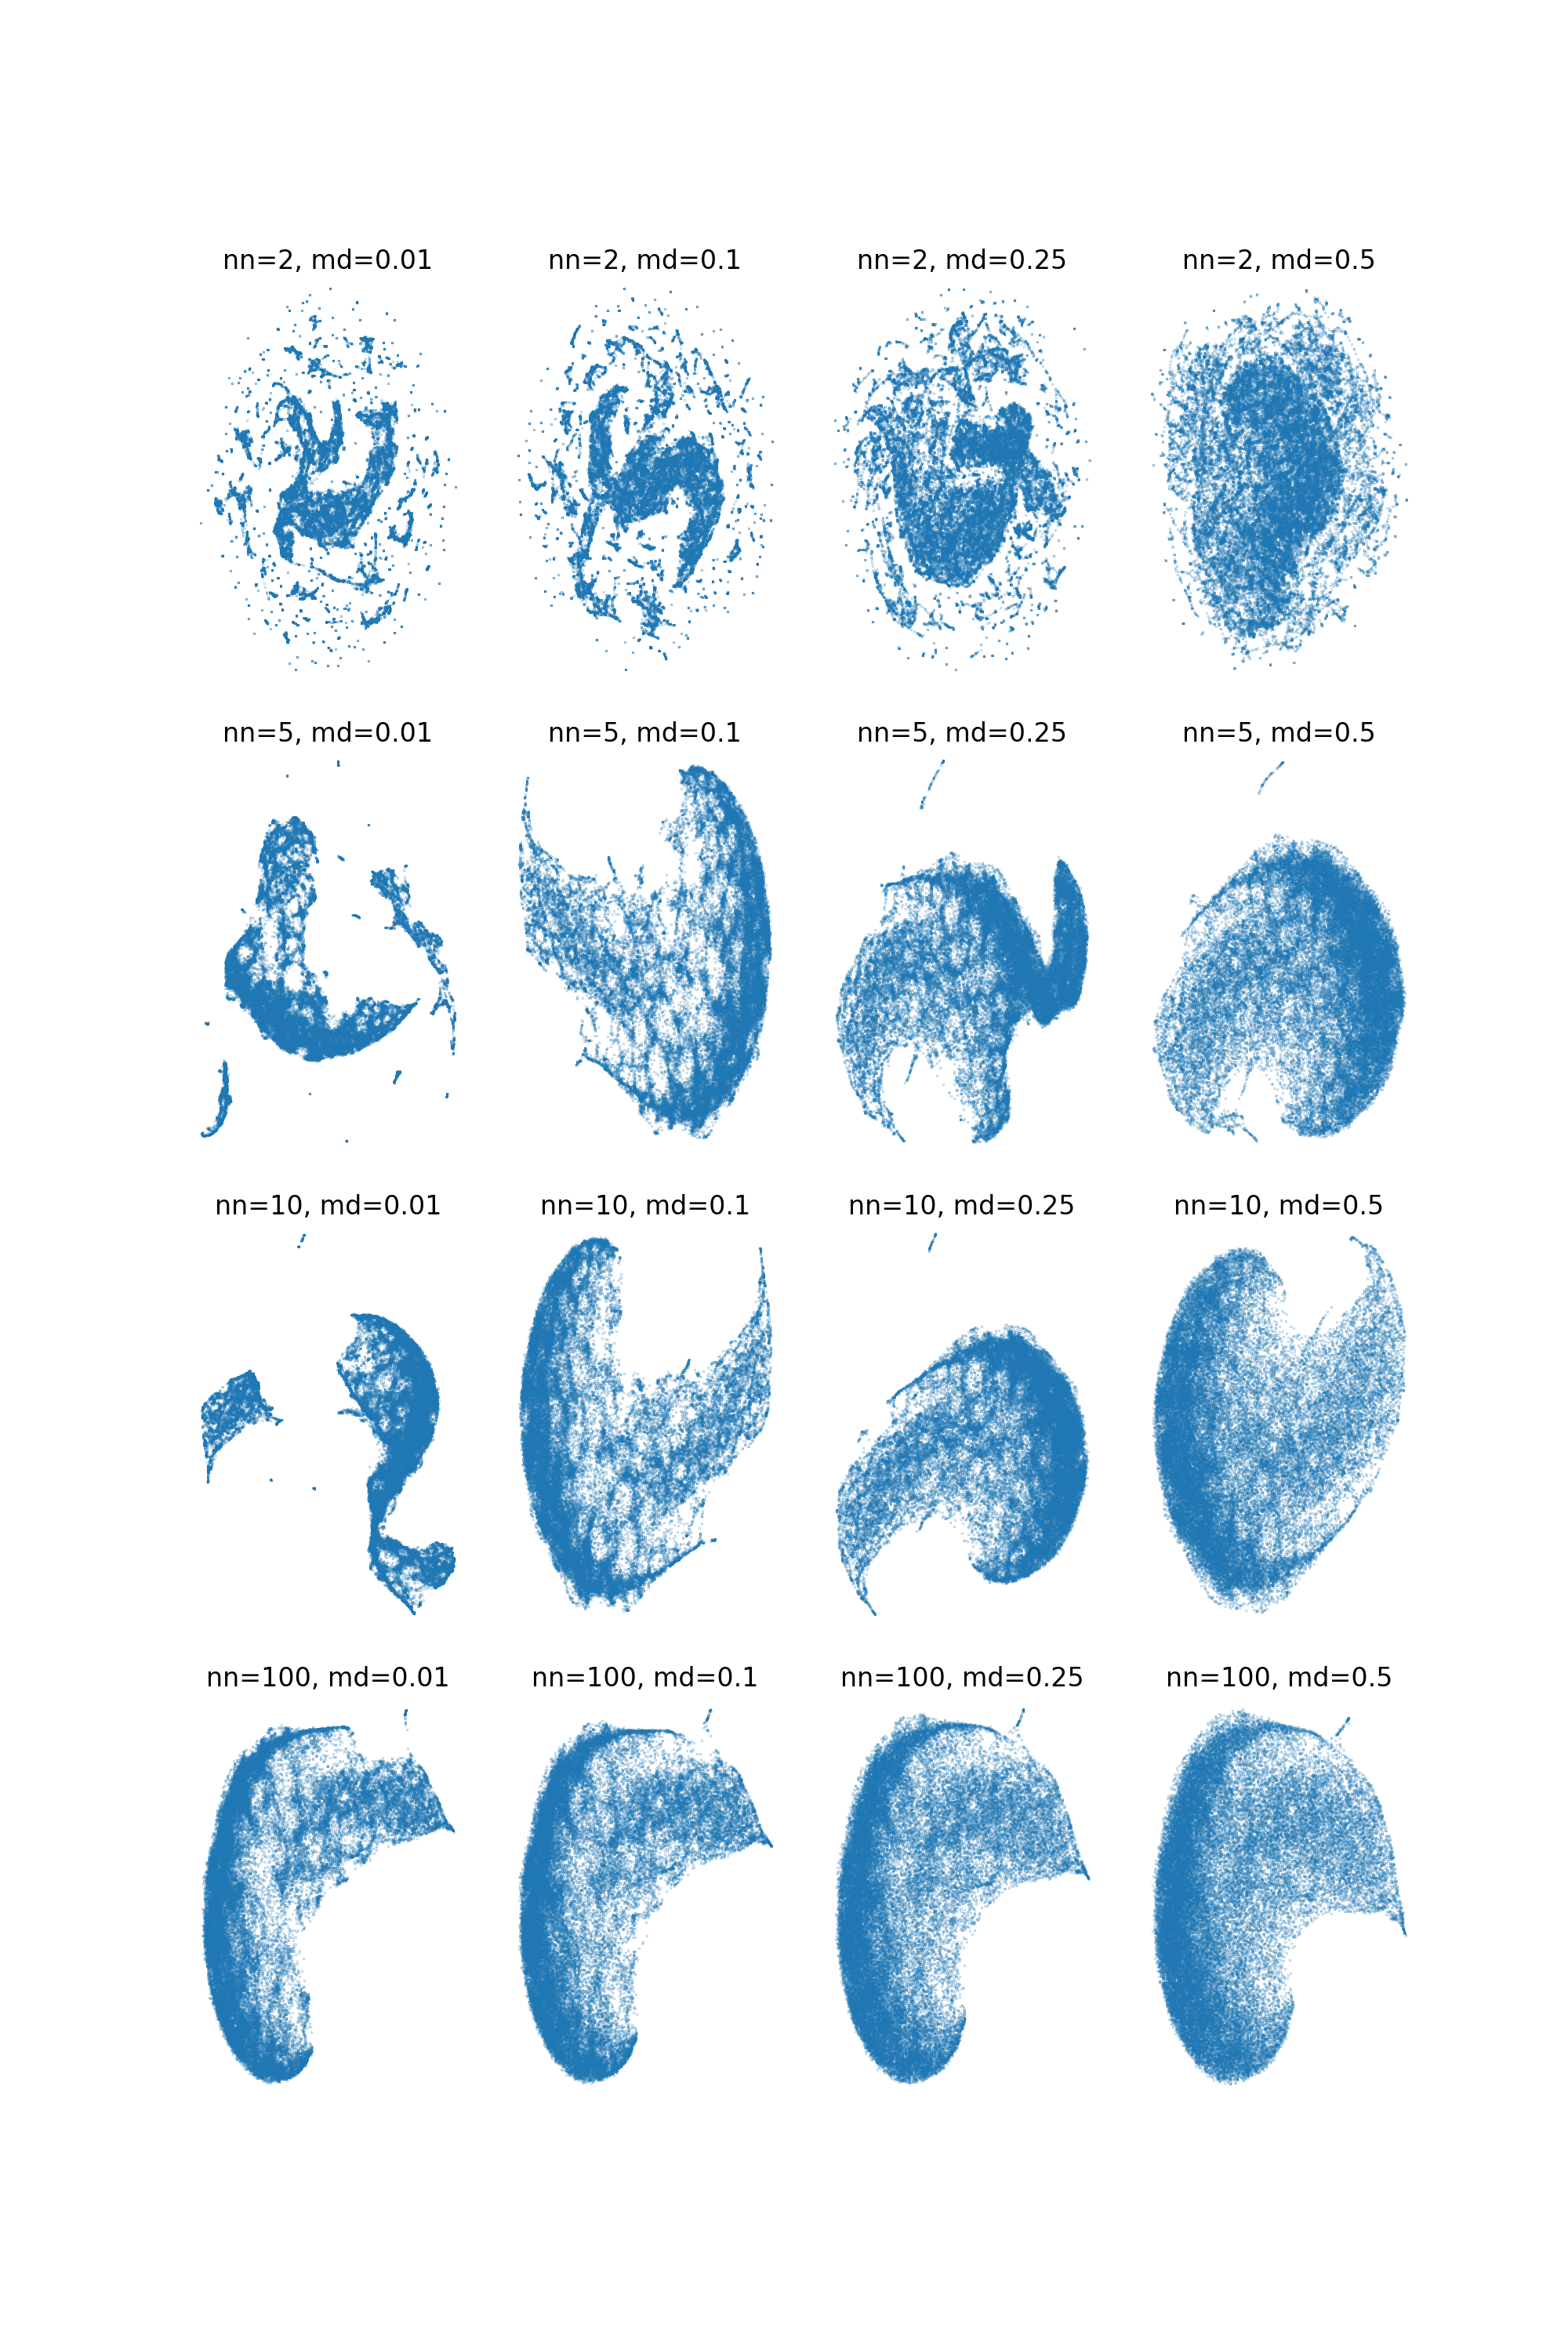

In [8]:
plt.figure(figsize = (10,15))
plt.title('different UMAP parameters for 50K galaxy spectra')

count = 1
for inn, nn in enumerate(nn_list):
    for imd, md in enumerate(md_list):
        umap_results = numpy.load('umap_results/umap_result_nn_{}_md_{}.npy'.format(nn,md))
        x = umap_results[:, 0]
        y = umap_results[:, 1]
        plt.subplot(4, 4, count)
        plt.title('nn={}, md={}'.format(nn, md))
        plt.scatter(x, y, s=0.01)
        plt.axis('off')
        plt.xlim(get_plot_limit(x))
        plt.ylim(get_plot_limit(y))
        
        count += 1
        
#plt.tight_layout()
plt.show()

# Coloring the UMAP
* Here we color the UMAP by measured properties of the galaxies

In [9]:
galSpecLine_df = pandas.read_csv('data/galSpecLine_df_red.csv') # Emission line measurements from MPA-JHU, see: 
# https://skyserver.sdss.org/dr14/en/help/browser/browser.aspx?cmd=description+galSpecLine+U#&&history=description+galSpecLine+U
hdew = numpy.load('data/hdew_red.npy') # H delta EW 
galSpecLine_df.describe()

Unnamed: 0   Unnamed: 0.1     SPECOBJID           MJD       PLATEID  \
count   50000.000000   50000.000000  5.000000e+04  27228.000000  27228.000000   
mean   124782.778600  124782.778600  2.472605e+18  53534.876377   1876.689033   
std     72185.187999   72185.187999  2.049129e+18    634.794979    558.158598   
min         7.000000       7.000000 -9.223372e+18  52368.000000    889.000000   
25%     62214.500000   62214.500000  9.526814e+17  53046.000000   1415.000000   
50%    124351.500000  124351.500000  1.991772e+18  53498.000000   1843.000000   
75%    187804.250000  187804.250000  2.933050e+18  54086.000000   2292.000000   
max    249842.000000  249842.000000  9.215566e+18  54653.000000   2974.000000   

            FIBERID  SIGMA_BALMER  SIGMA_BALMER_ERR  SIGMA_FORBIDDEN  \
count  27228.000000  27228.000000      27228.000000     27228.000000   
mean     332.788673    160.941205         25.442954       154.109079   
std      181.437155    147.906970        241.909954       124.446490   
min        1.000000     -2.126262         -0.000000         0.000000   
25%      176.000000     67.535507          0.906000        75.945733   
50%      339.000000    111.311768          6.384556       122.148705   
75%      492.000000    181.368143         27.029756       182.308688   
max      640.000000    500.000000      34052.336000       500.000000   

       SIGMA_FORBIDDEN_ERR      ...           OII_FLUX  OII_FLUX_ERR  \
count         27228.000000      ...       2.722800e+04  2.722800e+04   
mean             23.405097      ...       3.586425e+05  5.347372e+08   
std              76.401527      ...       7.928446e+07  3.369203e+10   
min              -0.000000      ...      -4.214452e+09  2.989268e-01   
25%               2.177729      ...       5.019499e+00  6.089957e+00   
50%              10.503228      ...       2.442265e+01  1.525563e+01   
75%              28.765645      ...       7.021820e+01  3.940536e+01   
max            4545.164600      ...       1.118273e+10  4.617003e+12   

           OII_VOFF      OII_CHI2    OIII_SIGMA     OIII_FLUX  OIII_FLUX_ERR  \
count  27228.000000  2.722800e+04  27228.000000  2.722800e+04   2.722800e+04   
mean       8.052902           inf    144.555169  7.868121e+04   5.600689e+03   
std      130.300970           NaN    128.576647  8.500026e+06   4.681825e+05   
min     -300.000000 -6.880891e+00     -0.000461 -6.328830e+06  -7.358318e-01   
25%      -53.379266  4.972507e-01     59.303420  8.003467e+00   2.845067e+00   
50%       -5.362957  7.598115e-01    110.425420  1.632024e+01   3.848186e+00   
75%       59.316812  1.057074e+00    185.341168  3.308779e+01   5.336406e+00   
max      300.000000           inf    500.000000  1.251530e+09   4.670479e+07   

          OIII_VOFF     OIII_CHI2   SPECTOFIBER  
count  27228.000000  2.722800e+04  2.722800e+04  
mean      17.128872           inf  2.576542e+03  
std      117.342532           NaN  2.406790e+05  
min     -300.000000 -3.642923e-02  1.586501e-01  
25%      -29.160620  4.643666e-01  7.247668e-01  
50%       -0.808788  7.054926e-01  7.416588e-01  
75%       41.932998  1.019195e+00  7.588505e-01  
max      300.000000           inf  3.293306e+07  

[8 rows x 243 columns]

<IPython.core.display.Javascript object>


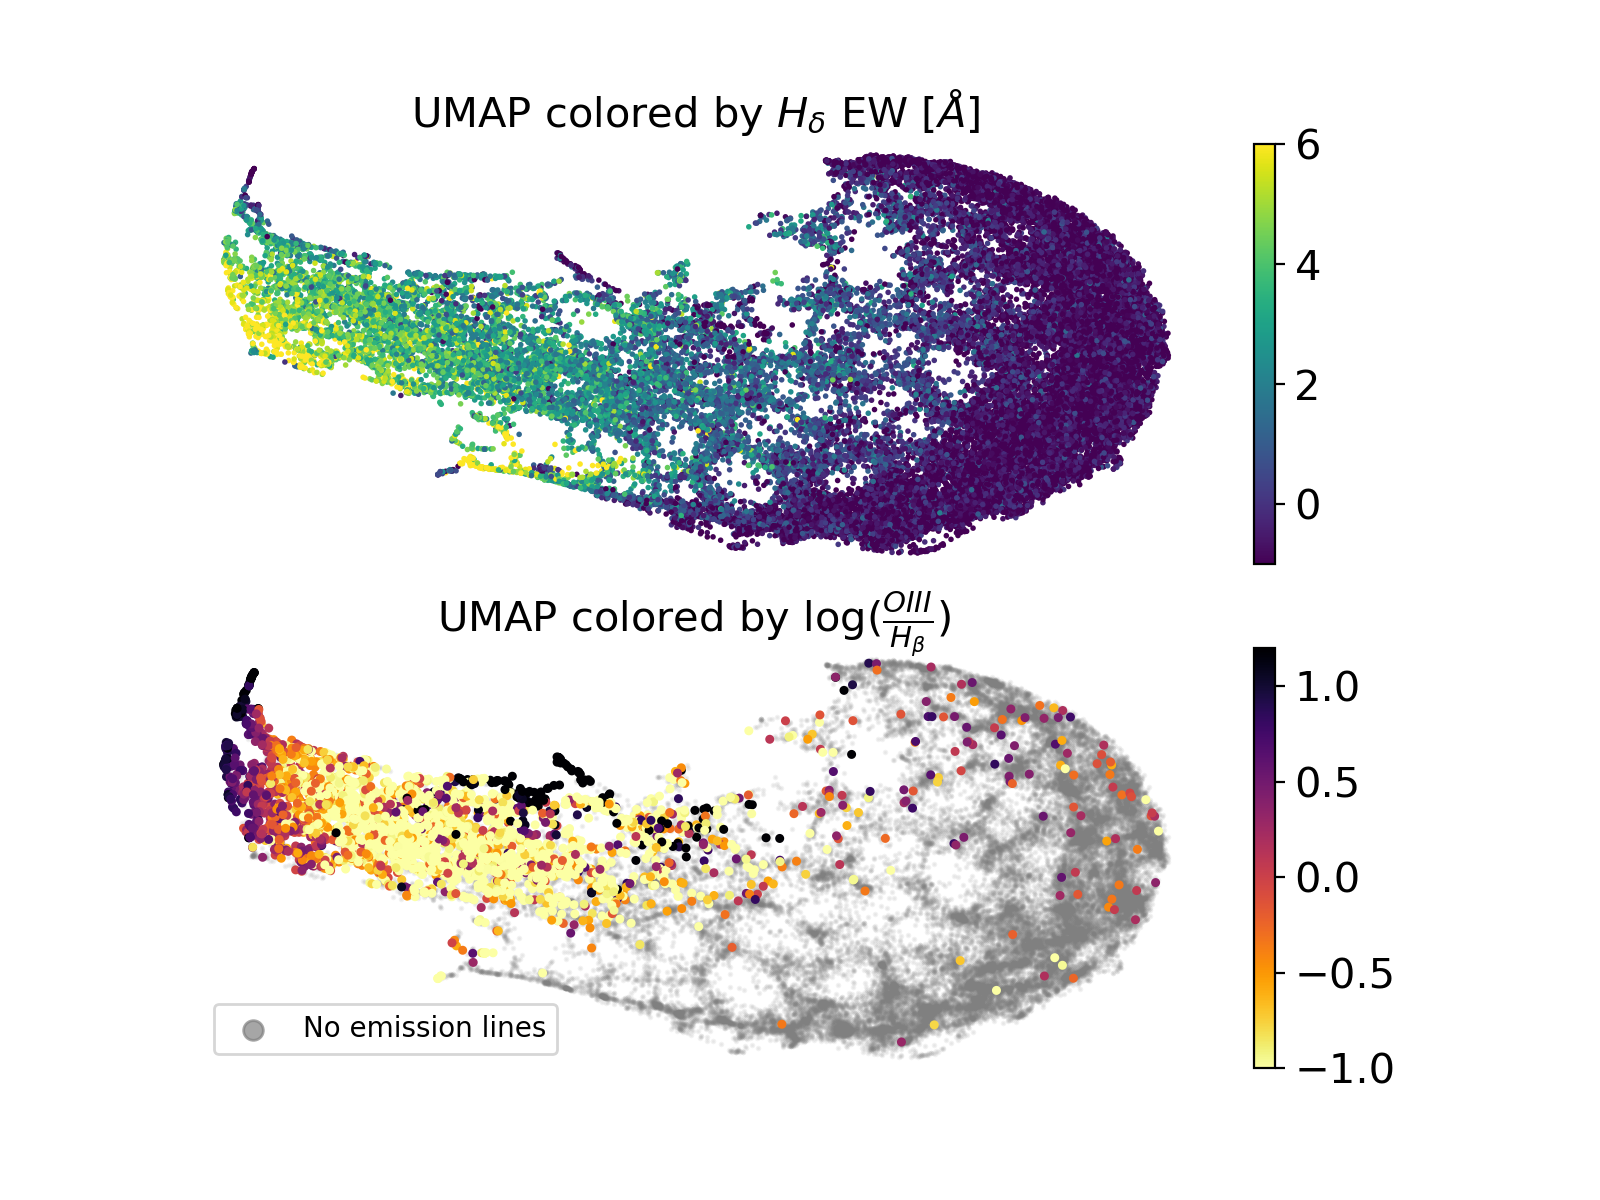

/Users/itamar/anaconda2/envs/ciwsa_/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in true_divide
/Users/itamar/anaconda2/envs/ciwsa_/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/Users/itamar/anaconda2/envs/ciwsa_/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log
/Users/itamar/anaconda2/envs/ciwsa_/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in log
/Users/itamar/anaconda2/envs/ciwsa_/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in greater
/Users/itamar/anaconda2/envs/ciwsa_/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in less
/Users/itamar/anaconda2/envs/ciwsa_/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in greater


In [10]:
plt.figure(figsize = (8,6))

umap_res = numpy.load('umap_results/umap_result_nn_5_md_0.1.npy')
umap_x = umap_res[:,0]
umap_y = umap_res[:,1]

plt.subplot(211)
plt.title('UMAP colored by $H_{\delta}$ EW [$\AA$]', fontsize = 15)

color = numpy.array(hdew).copy() 
cut = 6
color[color > cut] = cut
cut = -1
color[color < cut] = cut

finds = numpy.where(numpy.isfinite(color) )[0]
plt.scatter(umap_x[finds],umap_y[finds],s=1, c= color[finds])


plt.axis('off')
plt.xlim(get_plot_limit(umap_x))
plt.ylim(get_plot_limit(umap_y))

cb = plt.colorbar()
cb.ax.tick_params(labelsize = 15)

plt.subplot(212)
plt.title(r'UMAP colored by log($\frac{OIII}{H_{\beta}}$) ', fontsize = 15)

OIII = galSpecLine_df['OIII_FLUX'].values
Hb = galSpecLine_df['H_BETA_FLUX'].values

color = numpy.log(OIII/ Hb).copy() 
cut = 1.2
color[color > cut] = cut
cut = -1
color[color < cut] = cut

finds = numpy.where( numpy.isfinite(color) & (Hb > 100) )[0]
plt.scatter(umap_x,umap_y,s=1, c= 'gray', alpha = 0.1, label='No emission lines')
plt.scatter(umap_x[finds],umap_y[finds],s=5, c= color[finds], cmap = 'inferno_r')
lg = plt.legend(fontsize = 10)
lg.legendHandles[0]._sizes = [50]
lg.legendHandles[0].set_alpha(0.7)

plt.axis('off')
plt.xlim(get_plot_limit(umap_x))
plt.ylim(get_plot_limit(umap_y))

cb = plt.colorbar()
cb.ax.tick_params(labelsize = 15)

plt.show()

# Select galaxies from the UMAP
* Here you can interactively select glaxies from the map and plot their spectra. The selected indecies will be stored in 'selected_inds'. 4 groups are shown as an example.

In [11]:
[group_1, group_2, group_3, group_4] = numpy.load('data/example_galaxy_groups.npy')

<IPython.core.display.Javascript object>


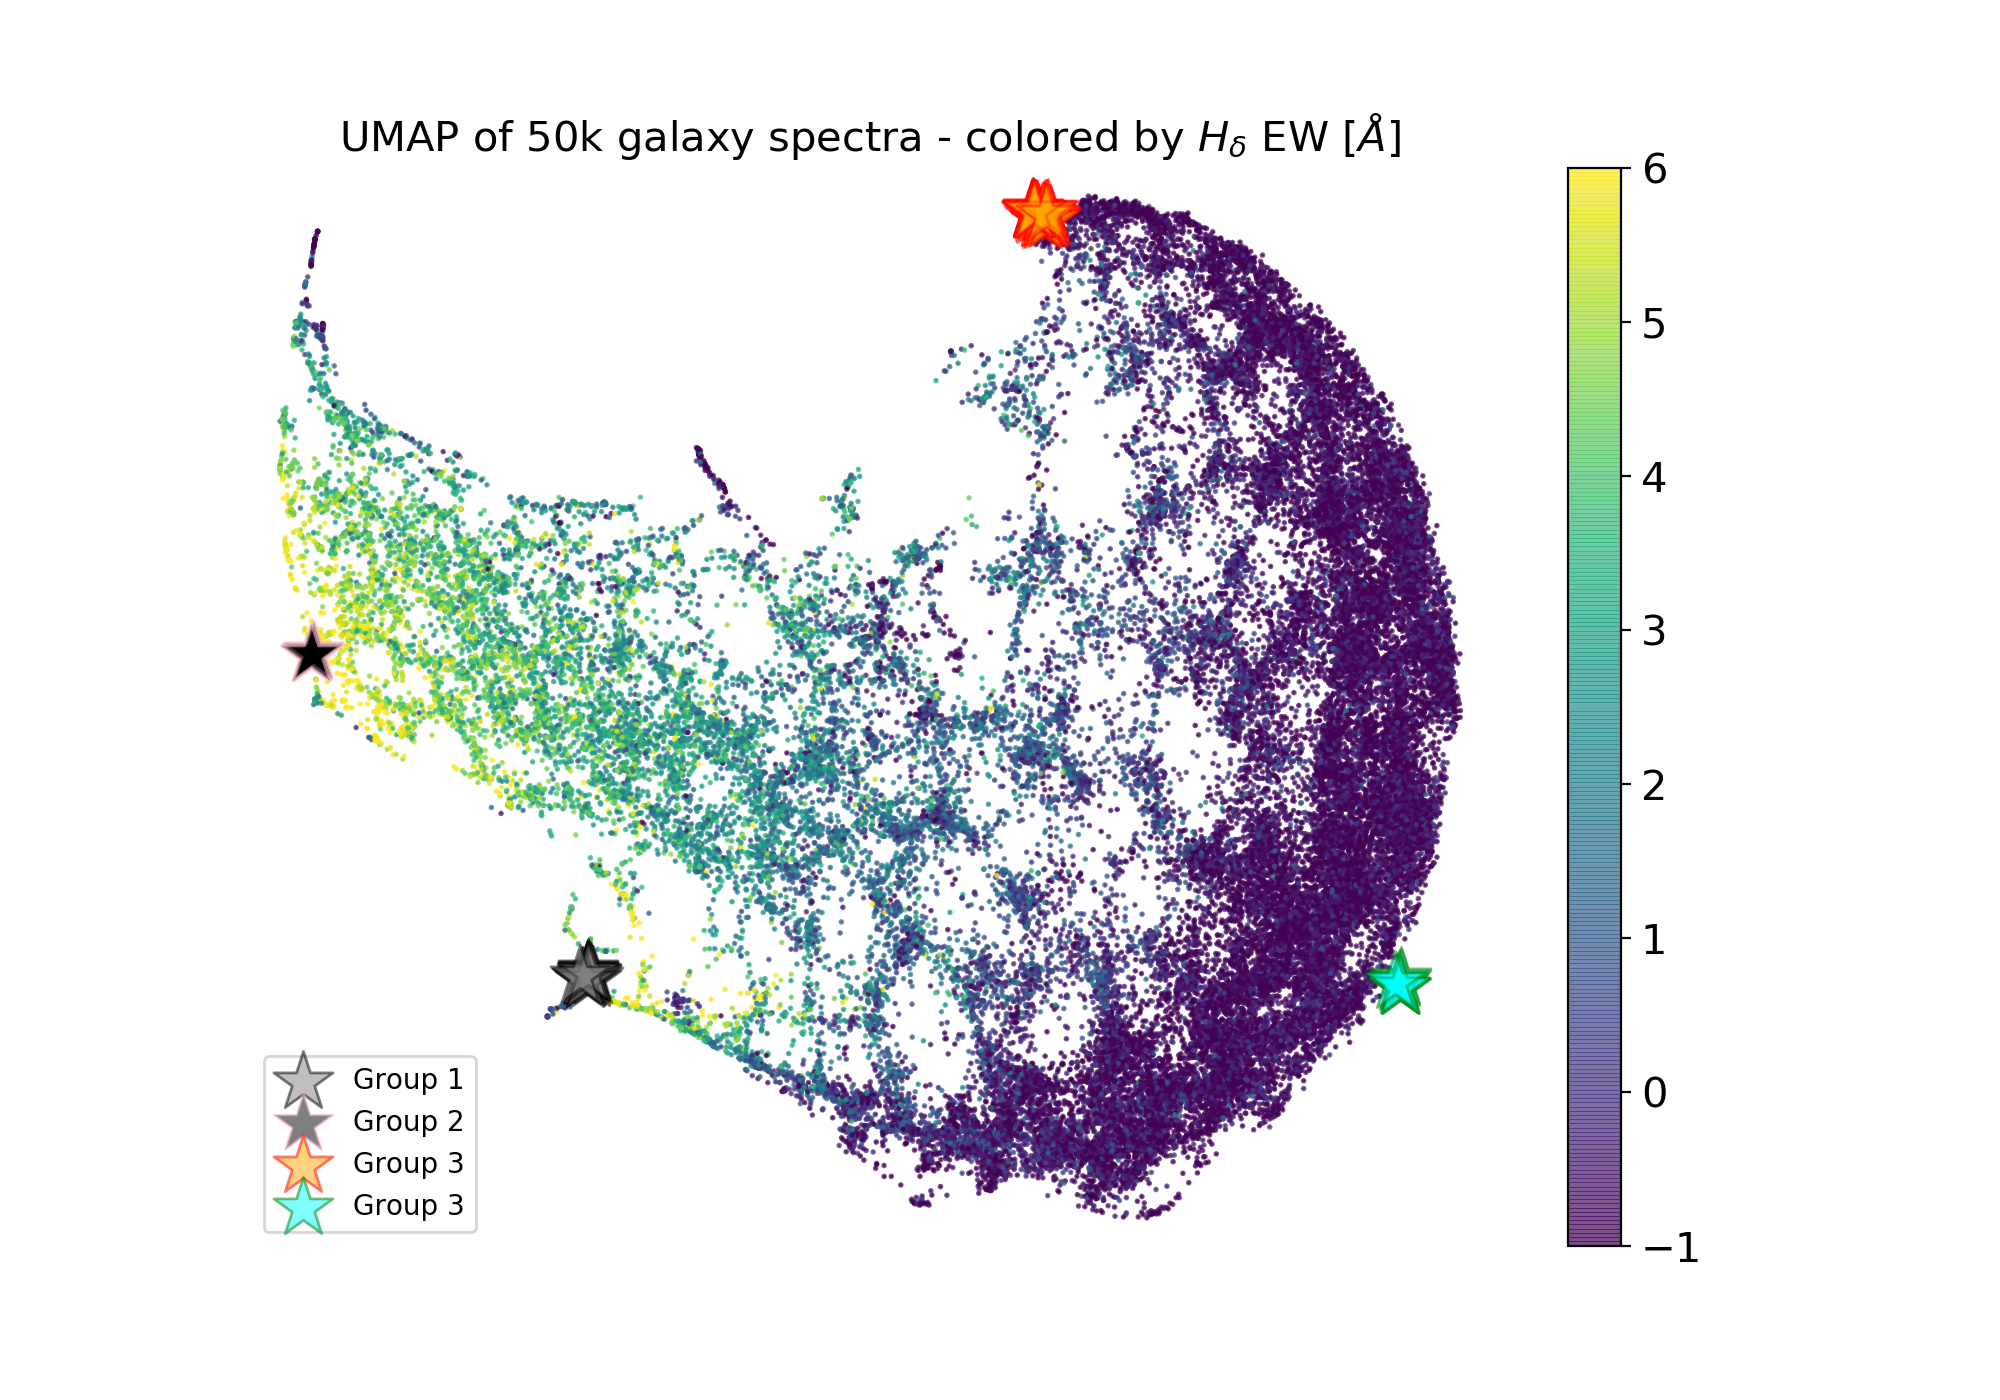

In [12]:
%matplotlib notebook

plt.figure(figsize = (10,7))

umap_x = umap_res[:,0]
umap_y = umap_res[:,1]
click_map = umap_res.copy()
color = numpy.array(hdew).copy() 
cut = 6
color[color > cut] = cut
cut = -1
color[color < cut] = cut

finds = numpy.where(numpy.isfinite(color) )[0]
plt.scatter(umap_x[finds],umap_y[finds],s=1, c= color[finds], alpha = 0.7)
cb = plt.colorbar()
cb.ax.tick_params(labelsize = 15)

plt.scatter(umap_x[group_1],umap_y[group_1],marker='*',s = 500, edgecolors='black', color='gray', alpha = 0.5, label ='Group 1')
plt.scatter(umap_x[group_2],umap_y[group_2],marker='*',s = 500, edgecolors='pink', color='black', alpha = 0.5, label ='Group 2')
plt.scatter(umap_x[group_3],umap_y[group_3],marker='*',s = 500, edgecolors='red', color='orange', alpha = 0.5, label ='Group 3')
plt.scatter(umap_x[group_4],umap_y[group_4],marker='*',s = 500, edgecolors='green', color='cyan', alpha = 0.5, label ='Group 3')


plt.legend(fontsize = 10)
plt.title('UMAP of 50k galaxy spectra - colored by $H_{\delta}$ EW [$\AA$]', fontsize = 15)
plt.axis('off')
plt.xlim(get_plot_limit(umap_x))
plt.ylim(get_plot_limit(umap_y))



plt.show()

current_ax = plt.gca()
#xn, xx = current_ax.get_xlim(); print(xn, xx)
#yn, yx = current_ax.get_ylim(); print(yn, yx)
toggle_selector.RS = RectangleSelector(current_ax, line_select_callback,
                                           drawtype='box', useblit=True,
                                           button=[1, 3],  # don't use middle button
                                           minspanx=5, minspany=5,
                                       spancoords='pixels',
                                           interactive=True)
event = plt.connect('key_press_event', toggle_selector)

<IPython.core.display.Javascript object>


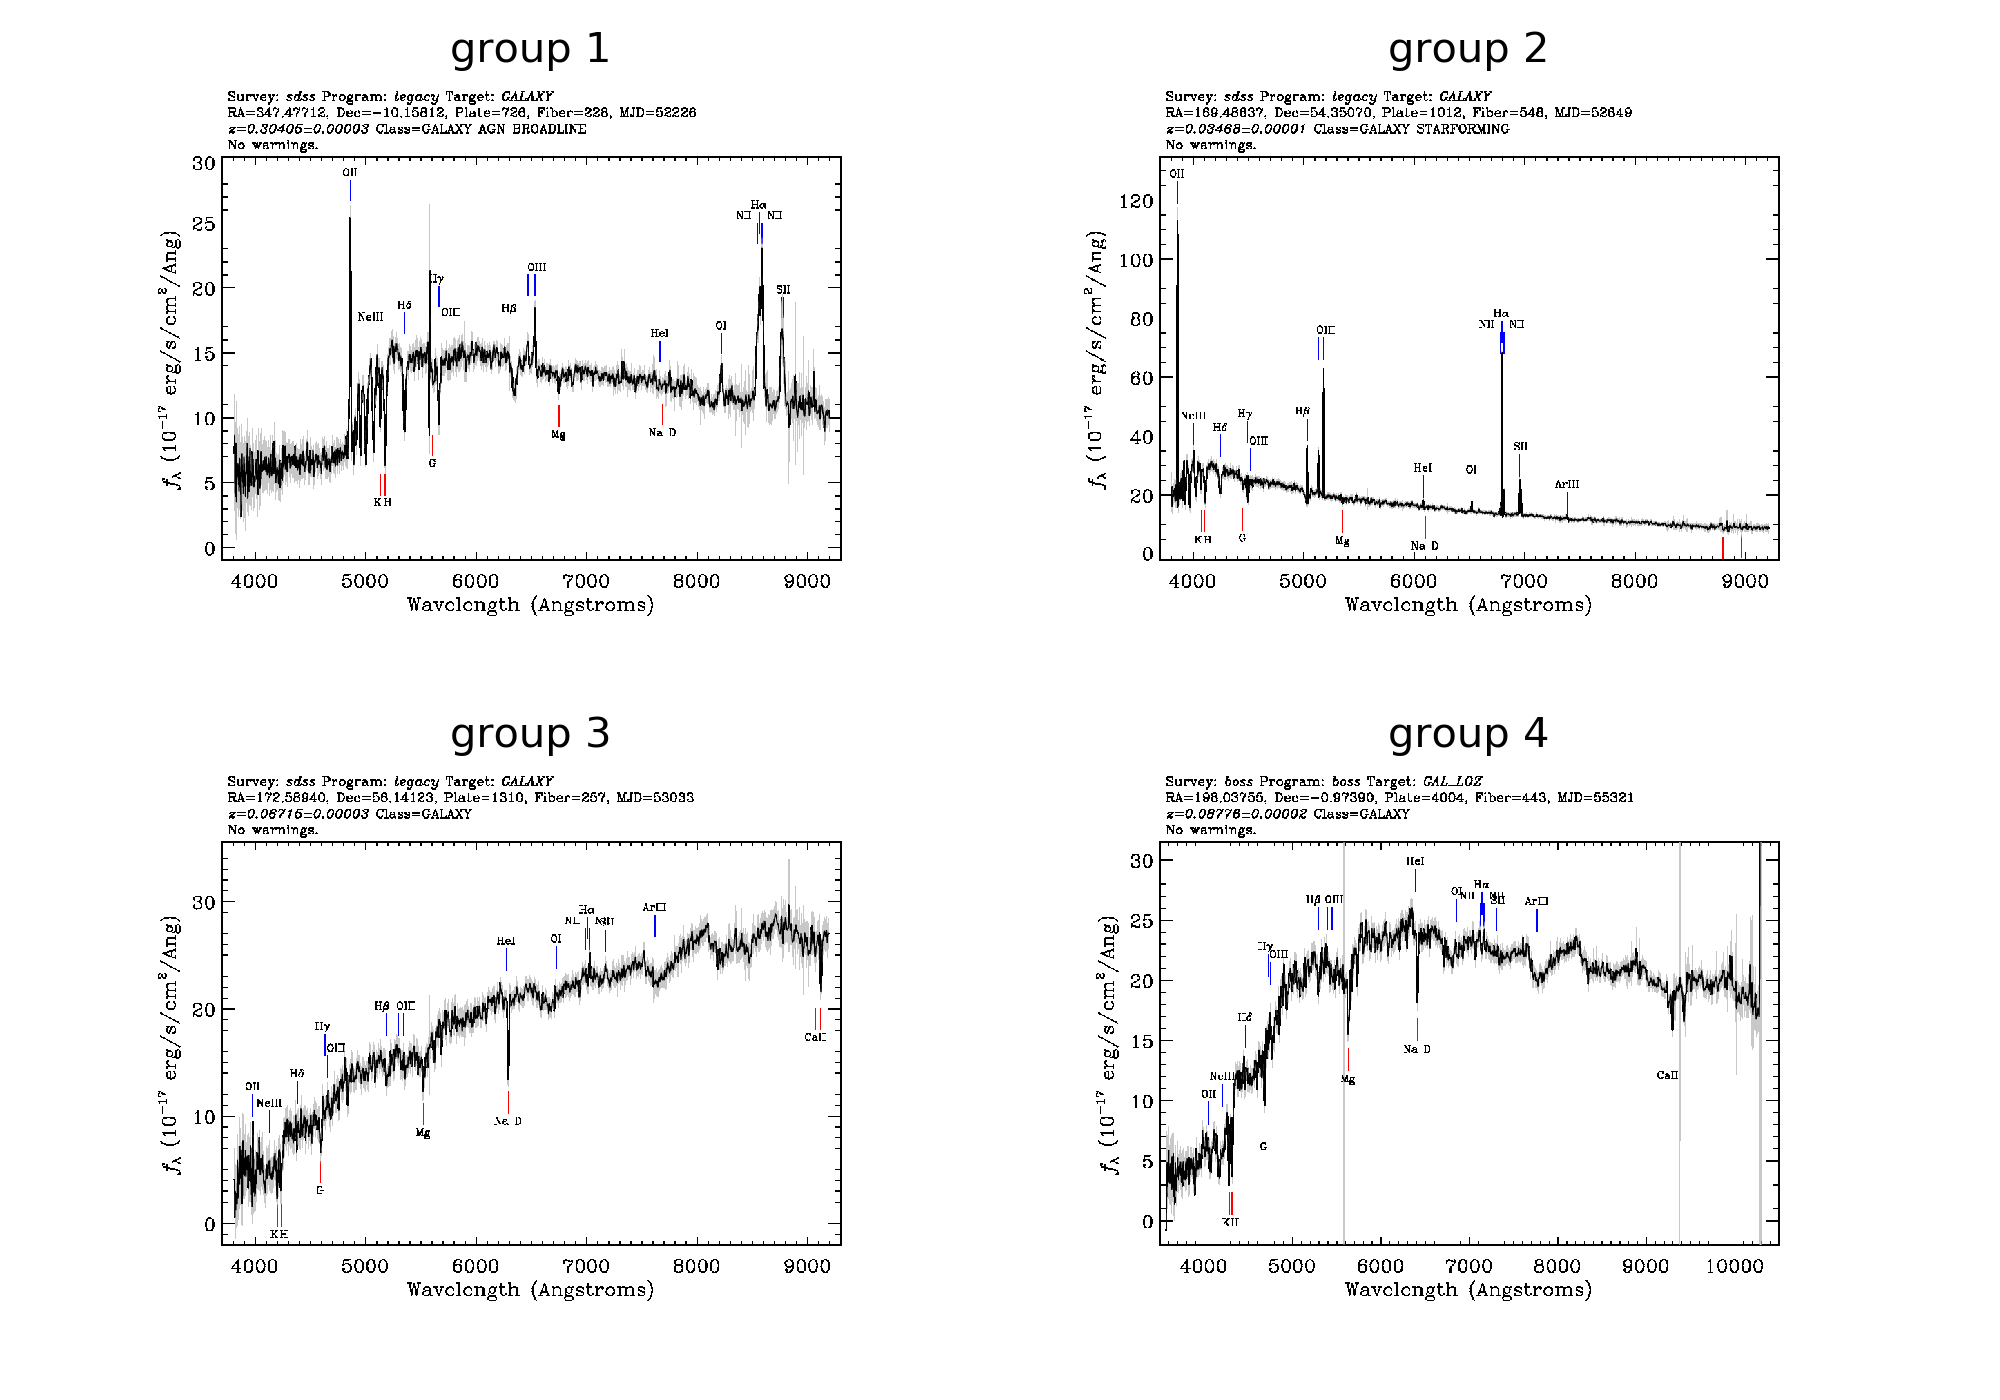

In [16]:
plt.figure(figsize = (10,7))

nrows = 2
ncols = 2

plt.subplot(nrows,ncols,1)
plt.title('group 1', fontsize = 15)
dr14_specobjid = str(SpecObjIDS[group_1[0]])
plt.imshow(mpimg.imread('http://skyserver.sdss.org/dr14/en/get/SpecById.ashx?id=' + dr14_specobjid))
plt.axis('off')
plt.tight_layout()

plt.subplot(nrows,ncols,2)
plt.title('group 2', fontsize = 15)
dr14_specobjid = str(SpecObjIDS[group_2[0]])
plt.imshow(mpimg.imread('http://skyserver.sdss.org/dr14/en/get/SpecById.ashx?id=' + dr14_specobjid))
plt.axis('off')
plt.tight_layout()

plt.subplot(nrows,ncols,3)
plt.title('group 3', fontsize = 15)
dr14_specobjid = str(SpecObjIDS[group_3[0]])
plt.imshow(mpimg.imread('http://skyserver.sdss.org/dr14/en/get/SpecById.ashx?id=' + dr14_specobjid))
plt.axis('off')
plt.tight_layout()

plt.subplot(nrows,ncols,4)
plt.title('group 4', fontsize = 15)
dr14_specobjid = str(SpecObjIDS[group_4[0]])
plt.imshow(mpimg.imread('http://skyserver.sdss.org/dr14/en/get/SpecById.ashx?id=' + dr14_specobjid))
plt.axis('off')
plt.tight_layout()

plt.show()

# Outliers
* We can define outliers as galaxies with the largest distance to their K-nearest neighbors. The code below shows the resulting outliers on the UMAP
* Note how changing k produces very different outliers

In [17]:
%%time
k1 = 100 
neighbors = NearestNeighbors(k1) # approximate nearest neighbor search in order to aviod calculating the full distance matrix
neighbors.fit(umap_res)
neighbors_distances = neighbors.kneighbors(umap_res, return_distance=True)[0]
k1_nn_dist = neighbors_distances[:,-1] # the UMAP distance to the k nearest neighbor
outliers_k1 = numpy.argsort(k1_nn_dist)[::-1][:100] # 100 galaxies with the largst distance to the k nearest neighbor

CPU times: user 1.32 s, sys: 143 ms, total: 1.46 s
Wall time: 1.7 s


In [18]:
%%time
k2 = 5  
neighbors = NearestNeighbors(k2)
neighbors.fit(umap_res)
neighbors_distances = neighbors.kneighbors(umap_res, return_distance=True)[0]
k2_nn_dist = neighbors_distances[:,-1] 
outliers_k2 = numpy.argsort(k2_nn_dist)[::-1][:100] 

CPU times: user 329 ms, sys: 11.4 ms, total: 340 ms
Wall time: 246 ms


In [19]:
def umap_outliers_plot(umap_, color_, outliers_, title_):
    umap_x = umap_[:,0]
    umap_y = umap_[:,1]
    color = color_.copy()
    cut = numpy.percentile(a=color,q = 1)
    color[color < cut] = cut
    cut = numpy.percentile(a=color,q = 99)
    color[color > cut] = cut

    plt.scatter(umap_x,umap_y,s=1, c = color, alpha = 0.5)
    cb = plt.colorbar()
    cb.set_ticks([])
    cb.set_label('Weirdness score', fontsize = 20)
    plt.scatter(umap_x[outliers_],umap_y[outliers_],marker='*',
                s = 500, edgecolors='pink', color='black', label ='Outliers')
    plt.legend(fontsize = 20)
    plt.title(title_, fontsize = 20)
    plt.axis('off')
    plt.xlim(get_plot_limit(umap_x))
    plt.ylim(get_plot_limit(umap_y))


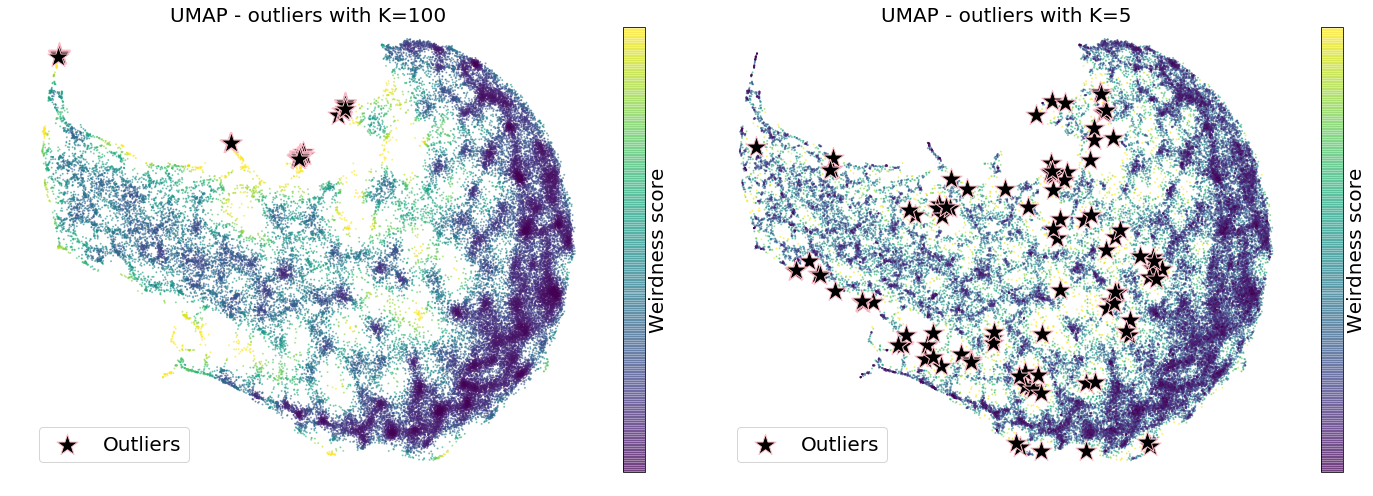

In [20]:
%matplotlib inline
plt.figure(figsize = (20,7))

nrows = 1
ncols = 2

plt.subplot(nrows,ncols,1)
umap_outliers_plot(umap_res, k1_nn_dist, outliers_k1, 'UMAP - outliers with K={}'.format(k1))

plt.subplot(nrows,ncols,2)
umap_outliers_plot(umap_res, k2_nn_dist, outliers_k2, 'UMAP - outliers with K={}'.format(k2))

plt.tight_layout()
plt.show()

http://skyserver.sdss.org/dr14/en/tools/explore/summary.aspx?sid=2888103208226416640&apid=


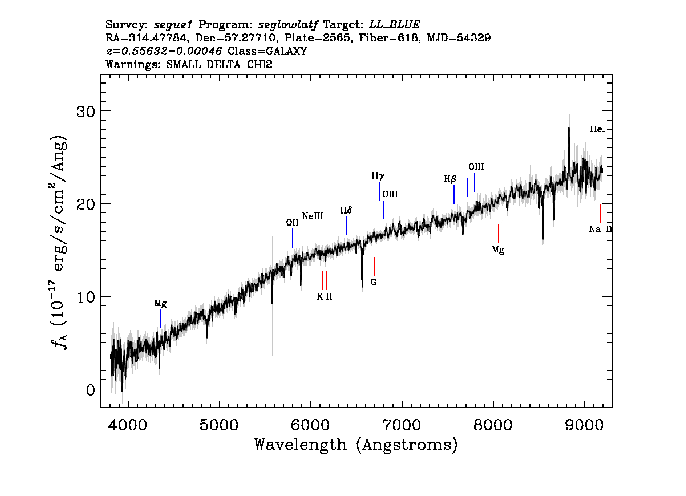

In [113]:
# Random outliers from k1
dr14_specobjid = str(SpecObjIDS[numpy.random.choice(outliers_k1)])
show_sdss_spectra(dr14_specobjid)

http://skyserver.sdss.org/dr14/en/tools/explore/summary.aspx?sid=551818804942891008&apid=


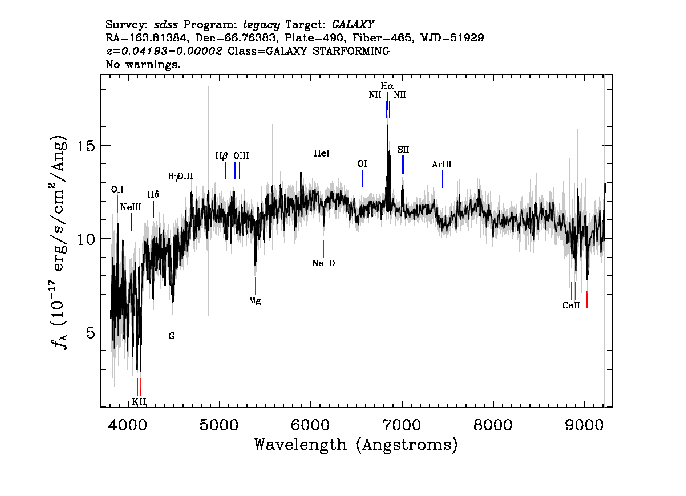

In [21]:
# Random outliers from k2
dr14_specobjid = str(SpecObjIDS[numpy.random.choice(outliers_k2)])
show_sdss_spectra(dr14_specobjid)